<a href="https://colab.research.google.com/github/gulabpatel/Feature-Engineering-Outlier-Detection/blob/master/IsolationForest_Anomaly_Detection_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
from datetime import datetime
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')

In [3]:
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10320 non-null  object
 1   value      10320 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.4+ KB


In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [6]:
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [7]:
df = df.set_index('timestamp').resample("H").mean().reset_index()

In [8]:
#Now, we are having hourly interval instead of 30 minutes
df.head()

,timestamp,value
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5


In [9]:
df['hour'] = df.timestamp.dt.hour

In [10]:
df['weekday'] = pd.Categorical(df.timestamp.dt.strftime('%A'), categories=['Monday','Tuesday','Wednesday','Thuesday','Friday','Saturday','Sunday'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5160 entries, 0 to 5159
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  5160 non-null   datetime64[ns]
 1   value      5160 non-null   float64       
 2   hour       5160 non-null   int64         
 3   weekday    4416 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 126.5 KB


In [12]:
df

,timestamp,value,hour,weekday
0,2014-07-01 00:00:00,9485.5,0,Tuesday
1,2014-07-01 01:00:00,5433.0,1,Tuesday
2,2014-07-01 02:00:00,3346.5,2,Tuesday
3,2014-07-01 03:00:00,2216.5,3,Tuesday
4,2014-07-01 04:00:00,2189.5,4,Tuesday
...,...,...,...,...
5155,2015-01-31 19:00:00,28288.5,19,Saturday
5156,2015-01-31 20:00:00,24138.0,20,Saturday
5157,2015-01-31 21:00:00,24194.5,21,Saturday
5158,2015-01-31 22:00:00,26515.0,22,Saturday


In [13]:
#df[['value','weekday']].groupby('weekday').mean()

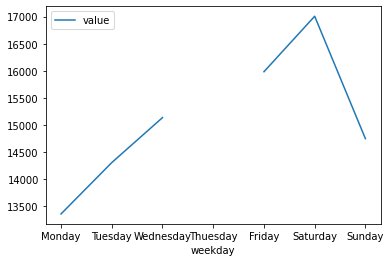

In [14]:
df[['value','weekday']].groupby('weekday').mean().plot()

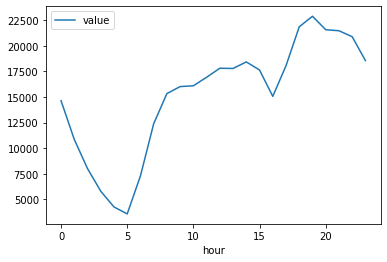

In [15]:
df[['value','hour']].groupby('hour').mean().plot()

In [18]:
fig = px.line(df.reset_index(), x='timestamp', y='value', title='NYC Taxi Demand')

fig.update_xaxes(
rangeslider_visible=True
)
fig.show()

Anomalous Point<br>
---
NYC Marathon - 2014-11-02<br>
Thanksgiving - 2014-11-27<br>
Christmas - 2014-12-25<br>
New Years - 2015-01-01<br>
Snow Blizzers - 2015-01-26 and 2015-01-27


In [19]:
model = IsolationForest(contamination=0.004)
model.fit(df[['value']])

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.004,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [20]:
df['outliers'] = pd.Series(model.predict(df[['value']])).apply(lambda x:'yes' if (x==-1) else 'no')

In [21]:
#Let's see what are the outliers
df.query('outliers == "yes"')

,timestamp,value,hour,weekday,outliers
1631,2014-09-06 23:00:00,29418.5,23,Saturday,yes
2135,2014-09-27 23:00:00,28024.5,23,Saturday,yes
2639,2014-10-18 23:00:00,28253.5,23,Saturday,yes
2807,2014-10-25 23:00:00,27554.5,23,Saturday,yes
2971,2014-11-01 19:00:00,27912.0,19,Saturday,yes
2977,2014-11-02 01:00:00,37204.5,1,Sunday,yes
3143,2014-11-08 23:00:00,27926.0,23,Saturday,yes
3311,2014-11-15 23:00:00,27713.0,23,Saturday,yes
3479,2014-11-22 23:00:00,28299.0,23,Saturday,yes
4413,2014-12-31 21:00:00,27559.5,21,Wednesday,yes


In [22]:
df

,timestamp,value,hour,weekday,outliers
0,2014-07-01 00:00:00,9485.5,0,Tuesday,no
1,2014-07-01 01:00:00,5433.0,1,Tuesday,no
2,2014-07-01 02:00:00,3346.5,2,Tuesday,no
3,2014-07-01 03:00:00,2216.5,3,Tuesday,no
4,2014-07-01 04:00:00,2189.5,4,Tuesday,no
...,...,...,...,...,...
5155,2015-01-31 19:00:00,28288.5,19,Saturday,yes
5156,2015-01-31 20:00:00,24138.0,20,Saturday,no
5157,2015-01-31 21:00:00,24194.5,21,Saturday,no
5158,2015-01-31 22:00:00,26515.0,22,Saturday,no


In [25]:
fig = px.scatter(df.reset_index(), x = 'timestamp', y='value', color='outliers', hover_data=['weekday'], title='NYC Taxi Demand')

fig.update_xaxes(
    rangeslider_visible=True
)
fig.show()

/usr/local/lib/python3.6/dist-packages/plotly/express/_core.py:286: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [26]:
#Second way to identify the outliers
model = IsolationForest()
model.fit(df[['value']])

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [28]:
#Use score function instead predict function
score = model.decision_function(df[['value']])

In [29]:
score

array([-0.02744455, -0.04135719, -0.00539939, ..., -0.0382749 ,
       -0.11524617, -0.11592692])

(array([  2.,   5.,   1.,   2.,   6.,   4.,  14.,   2.,   7.,   4.,   0.,
          4.,   3.,   6.,  11.,   8.,   9.,  16.,  31.,  11.,  12.,  21.,
         16.,  43.,  31.,  50.,  50., 106., 205., 152., 281., 327., 240.,
        201., 170., 332., 277., 320.,  55.,  82., 138., 153., 201.,  80.,
        153., 136., 199., 194., 474., 315.]),
 array([-0.23588476, -0.22947511, -0.22306547, -0.21665583, -0.21024619,
        -0.20383655, -0.1974269 , -0.19101726, -0.18460762, -0.17819798,
        -0.17178834, -0.16537869, -0.15896905, -0.15255941, -0.14614977,
        -0.13974013, -0.13333048, -0.12692084, -0.1205112 , -0.11410156,
        -0.10769192, -0.10128227, -0.09487263, -0.08846299, -0.08205335,
        -0.07564371, -0.06923406, -0.06282442, -0.05641478, -0.05000514,
        -0.04359549, -0.03718585, -0.03077621, -0.02436657, -0.01795693,
        -0.01154728, -0.00513764,  0.001272  ,  0.00768164,  0.01409128,
         0.02050093,  0.02691057,  0.03332021,  0.03972985,  0.04613949,
 

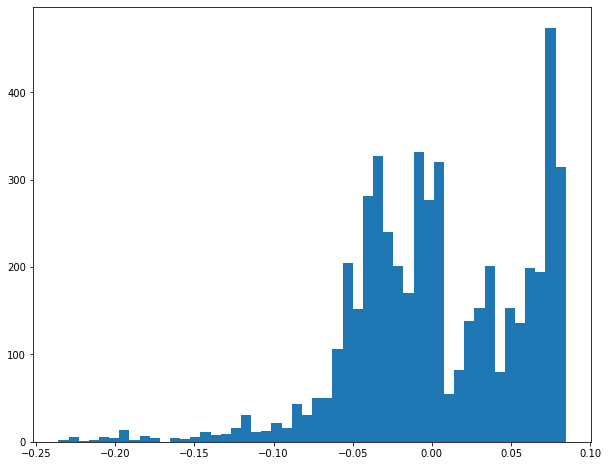

In [30]:
plt.hist(score, bins=50)

In [31]:
df['score'] = score

In [32]:
df

,timestamp,value,hour,weekday,outliers,score
0,2014-07-01 00:00:00,9485.5,0,Tuesday,no,-0.027445
1,2014-07-01 01:00:00,5433.0,1,Tuesday,no,-0.041357
2,2014-07-01 02:00:00,3346.5,2,Tuesday,no,-0.005399
3,2014-07-01 03:00:00,2216.5,3,Tuesday,no,-0.055185
4,2014-07-01 04:00:00,2189.5,4,Tuesday,no,-0.064901
...,...,...,...,...,...,...
5155,2015-01-31 19:00:00,28288.5,19,Saturday,yes,-0.225012
5156,2015-01-31 20:00:00,24138.0,20,Saturday,no,-0.031821
5157,2015-01-31 21:00:00,24194.5,21,Saturday,no,-0.038275
5158,2015-01-31 22:00:00,26515.0,22,Saturday,no,-0.115246


In [33]:
df.query('score< -.20')

,timestamp,value,hour,weekday,outliers,score
1631,2014-09-06 23:00:00,29418.5,23,Saturday,yes,-0.230923
2135,2014-09-27 23:00:00,28024.5,23,Saturday,yes,-0.219121
2639,2014-10-18 23:00:00,28253.5,23,Saturday,yes,-0.225012
2807,2014-10-25 23:00:00,27554.5,23,Saturday,yes,-0.206652
2971,2014-11-01 19:00:00,27912.0,19,Saturday,yes,-0.211860
2977,2014-11-02 01:00:00,37204.5,1,Sunday,yes,-0.235885
3118,2014-11-07 22:00:00,27471.0,22,Friday,no,-0.200324
3143,2014-11-08 23:00:00,27926.0,23,Saturday,yes,-0.213306
3311,2014-11-15 23:00:00,27713.0,23,Saturday,yes,-0.209456
3479,2014-11-22 23:00:00,28299.0,23,Saturday,yes,-0.225012


Supporting youtube video https://www.youtube.com/watch?v=hkXPdkPfgoo

Conclusion: In this case Isolation Forest is not that good for anomaly detection but FBProphet performs better